# Intro to tensor flow

- Based on the [tensoflow tutorials](https://www.tensorflow.org/versions/r0.9/tutorials/index.html)

In [26]:
#Basic libraries
import numpy as np
import tensorflow as tf

#Show images
import matplotlib.pyplot as plt
%matplotlib inline
# plt configuration
plt.rcParams['figure.figsize'] = (10, 10)        # size of images
plt.rcParams['image.interpolation'] = 'nearest'  # show exact image
plt.rcParams['image.cmap'] = 'gray'  # use grayscale 


## Get some data

In [3]:
data_path = '/home/jorge/data/training/tensorflow/'
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(data_path + 'MNIST_data', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /home/jorge/data/training/tensorflow/MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /home/jorge/data/training/tensorflow/MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /home/jorge/data/training/tensorflow/MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /home/jorge/data/training/tensorflow/MNIST_data/t10k-labels-idx1-ubyte.gz


Train shape:  (55000, 784)
Valid shape:  (5000, 784)
Test  shape:  (10000, 784)


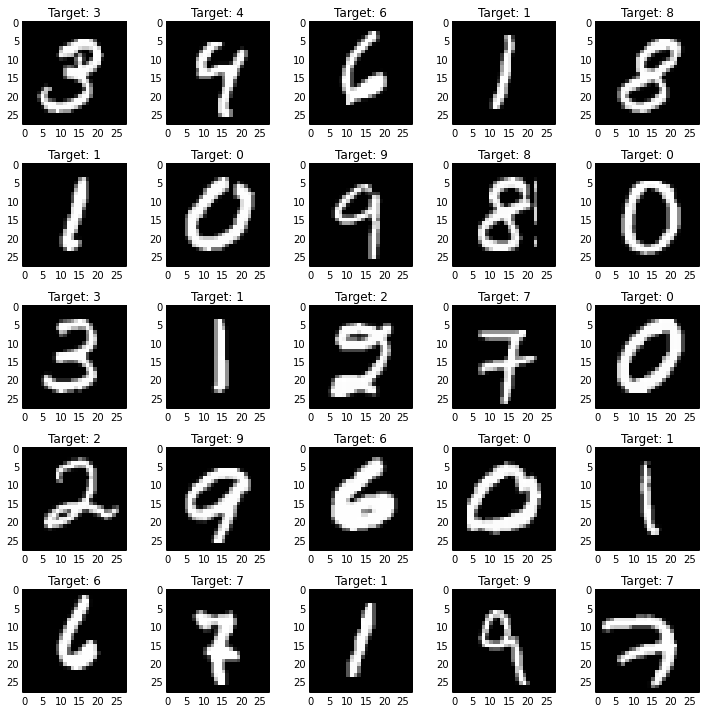

In [28]:
#Examine the data
print 'Train shape: ', mnist.train.images.shape
print 'Valid shape: ', mnist.validation.images.shape
print 'Test  shape: ', mnist.test.images.shape

fig = plt.figure()
for i in xrange(25):
    a = fig.add_subplot(5,5,i)
    a.set_title('Target: ' + str(np.argmax(mnist.train.labels[i])))
    fig.tight_layout()
    plt.imshow(np.reshape(mnist.train.images[i],(28,28)))



## First linear model

In [39]:
# Start an interactive session
sess = tf.InteractiveSession()


### Define the graph

# Inputs
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

# Model variables
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

# Define the trainer
y = tf.nn.softmax(tf.matmul(x,W) + b)
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)


# Train graph
sess.run(tf.initialize_all_variables())
for i in range(1000):
    batch = mnist.train.next_batch(50)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})

    
# Predict and evaluate    
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

#When finish, close the interactive session
sess.close()

0.9092


## The same model with skflow

In [80]:
import tensorflow.contrib.learn as skflow
from sklearn import datasets, metrics

#Convert target from dummy vars to a multinomial target
not_binary_target_train = [np.argmax(label) for label in mnist.train.labels]
not_binary_target_test = [np.argmax(label) for label in mnist.test.labels]

classifier = skflow.TensorFlowLinearClassifier(n_classes=10, batch_size=50, steps=1000, learning_rate=0.01)
classifier.fit(mnist.train.images, not_binary_target_train)

score = metrics.accuracy_score(not_binary_target_test, classifier.predict(mnist.test.images))
print("Test accuracy: %f" % score)

Step #99, avg. train loss: 1.47584
Step #199, avg. train loss: 0.91700
Step #299, avg. train loss: 0.73234
Step #399, avg. train loss: 0.66222
Step #499, avg. train loss: 0.60480
Step #599, avg. train loss: 0.57569
Step #699, avg. train loss: 0.53160
Step #799, avg. train loss: 0.52128
Step #899, avg. train loss: 0.50346
Step #999, avg. train loss: 0.50972
Test accuracy: 0.889200


## A convolutional model from scrach

In [43]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In [45]:
# Start an interactive session
sess = tf.InteractiveSession()

#Create the net

#Reshape input data
x_image = tf.reshape(x, [-1,28,28,1])


# First convolution
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)


#Second convolution
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)


#Full connect layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


#Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


#Finar linear layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])


#Prediction
y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)


# Loss function
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))


#Optimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)


#Accuracy
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))




In [46]:
#Inicialization.
sess.run(tf.initialize_all_variables())

# Train proccess
for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})


step 0, training accuracy 0.04
step 100, training accuracy 0.84
step 200, training accuracy 0.9
step 300, training accuracy 0.96
step 400, training accuracy 0.94
step 500, training accuracy 0.88
step 600, training accuracy 0.98
step 700, training accuracy 0.9
step 800, training accuracy 0.94
step 900, training accuracy 0.9
step 1000, training accuracy 0.96
step 1100, training accuracy 0.98
step 1200, training accuracy 0.98
step 1300, training accuracy 0.96
step 1400, training accuracy 0.9
step 1500, training accuracy 0.98
step 1600, training accuracy 1
step 1700, training accuracy 1
step 1800, training accuracy 0.94
step 1900, training accuracy 1
step 2000, training accuracy 0.98
step 2100, training accuracy 0.98
step 2200, training accuracy 0.98
step 2300, training accuracy 1
step 2400, training accuracy 1
step 2500, training accuracy 0.96
step 2600, training accuracy 0.98
step 2700, training accuracy 0.98
step 2800, training accuracy 0.94
step 2900, training accuracy 0.98
step 3000, 

ResourceExhaustedError: OOM when allocating tensor with shape[10000,28,28,32]
	 [[Node: Conv2D_2 = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Reshape_2, Variable_10/read)]]
	 [[Node: Mean_2/_1021 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_989_Mean_2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
Caused by op u'Conv2D_2', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/IPython/config/application.py", line 574, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/IPython/kernel/zmq/kernelapp.py", line 373, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 840, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/kernel/zmq/kernelbase.py", line 252, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/IPython/kernel/zmq/kernelbase.py", line 213, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/IPython/kernel/zmq/kernelbase.py", line 362, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/IPython/kernel/zmq/ipkernel.py", line 181, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2871, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 3035, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-cb212cda2372>", line 11, in <module>
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
  File "<ipython-input-43-5c108f5d264a>", line 10, in conv2d
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 295, in conv2d
    data_format=data_format, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/op_def_library.py", line 655, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2154, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1154, in __init__
    self._traceback = _extract_stack()


In [49]:
acc_test = 0
for i in range(100):
    batch = mnist.test.next_batch(100)
    acc_test += accuracy.eval(feed_dict = {x:batch[0], y_: batch[1], keep_prob: 1.0})
print "test accuracy: ", acc_test/100.0

test accuracy:  0.993000004292


In [ ]:
sess.close()

## The same model with skflow

In [84]:
import tensorflow.contrib.learn as learn
from sklearn import datasets, metrics

def conv_model(X, y):
    X = tf.reshape(X, [-1, 28, 28, 1])
    with tf.variable_scope('conv_layer1'):
        h_conv1 = learn.ops.conv2d(X, n_filters=32, filter_shape=[5, 5], strides=[1, 1, 1, 1], padding='SAME',
                                bias=True, activation=tf.nn.relu)
        h_pool1 = max_pool_2x2(h_conv1)
    # second conv layer will compute 64 features for each 5x5 patch
    with tf.variable_scope('conv_layer2'):
        h_conv2 = learn.ops.conv2d(h_pool1, n_filters=64, filter_shape=[5, 5], strides=[1, 1, 1, 1], padding='SAME', 
                                    bias=True, activation=tf.nn.relu)
        h_pool2 = max_pool_2x2(h_conv2)
        # reshape tensor into a batch of vectors
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
    # densely connected layer with 1024 neurons
    h_fc1 = learn.ops.dnn(h_pool2_flat, [1024], activation=tf.nn.relu, dropout=0.5)
    return learn.models.logistic_regression(h_fc1, y)

# Training and predicting
classifier = learn.TensorFlowEstimator(
    model_fn=conv_model, n_classes=10, batch_size=100, steps=20000, optimizer='Adam', 
    learning_rate=1e-4)
classifier.fit(mnist.train.images, not_binary_target_train)

score = metrics.accuracy_score(not_binary_target_test, classifier.predict(mnist.test.images))
print('Accuracy: {0:f}'.format(score))



Step #99, avg. train loss: 1.67569
Step #199, avg. train loss: 0.62593
Step #299, avg. train loss: 0.41760
Step #399, avg. train loss: 0.33255
Step #499, avg. train loss: 0.26920
Step #600, epoch #1, avg. train loss: 0.24119
Step #700, epoch #1, avg. train loss: 0.19257
Step #800, epoch #1, avg. train loss: 0.17090
Step #900, epoch #1, avg. train loss: 0.14982
Step #1000, epoch #1, avg. train loss: 0.13452
Step #1100, epoch #2, avg. train loss: 0.13391
Step #1200, epoch #2, avg. train loss: 0.11491
Step #1300, epoch #2, avg. train loss: 0.11588
Step #1400, epoch #2, avg. train loss: 0.09658
Step #1500, epoch #2, avg. train loss: 0.10116
Step #1600, epoch #2, avg. train loss: 0.09602
Step #1700, epoch #3, avg. train loss: 0.08451
Step #1800, epoch #3, avg. train loss: 0.07995
Step #1900, epoch #3, avg. train loss: 0.07665
Step #2000, epoch #3, avg. train loss: 0.07515
Step #2100, epoch #3, avg. train loss: 0.08154
Step #2200, epoch #4, avg. train loss: 0.07486
Step #2300, epoch #4, avg.

## Use the val_monitor to show the net

Based on https://www.tensorflow.org/versions/r0.7/how_tos/summaries_and_tensorboard/index.html 

In [1]:
import tensorflow as tf

# Start an interactive session
sess = tf.InteractiveSession()


In [85]:
# Create the model
x = tf.placeholder(tf.float32, [None, 784], name="x-input")
W = tf.Variable(tf.zeros([784,10]), name="weights")
b = tf.Variable(tf.zeros([10], name="bias"))

# use a name scope to organize nodes in the graph visualizer
with tf.name_scope("Wx_b") as scope:
    y = tf.nn.softmax(tf.matmul(x,W) + b)

# Add summary ops to collect data
w_hist = tf.histogram_summary("weights", W)
b_hist = tf.histogram_summary("biases", b)
y_hist = tf.histogram_summary("y", y)

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None,10], name="y-input")
# More name scopes will clean up the graph representation
with tf.name_scope("xent") as scope:
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    ce_summ = tf.scalar_summary("cross entropy", cross_entropy)
with tf.name_scope("train") as scope:
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

with tf.name_scope("test") as scope:
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    accuracy_summary = tf.scalar_summary("accuracy", accuracy)

# Merge all the summaries and write them out to /tmp/mnist_logs
merged = tf.merge_all_summaries()
writer = tf.train.SummaryWriter("/tmp/mnist_logs", sess.graph_def)
tf.initialize_all_variables().run()

# Train the model, and feed in test data and record summaries every 10 steps

for i in range(1000):
    if i % 10 == 0:  # Record summary data, and the accuracy
        feed = {x: mnist.test.images, y_: mnist.test.labels}
        result = sess.run([merged, accuracy], feed_dict=feed)
        summary_str = result[0]
        acc = result[1]
        writer.add_summary(summary_str, i)
        print("Accuracy at step %s: %s" % (i, acc))
    else:
        batch_xs, batch_ys = mnist.train.next_batch(100)
        feed = {x: batch_xs, y_: batch_ys}
        sess.run(train_step, feed_dict=feed)

print(accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

Accuracy at step 0: 0.098
Accuracy at step 10: 0.7114
Accuracy at step 20: 0.7218
Accuracy at step 30: 0.8577
Accuracy at step 40: 0.8535
Accuracy at step 50: 0.8774
Accuracy at step 60: 0.8681
Accuracy at step 70: 0.8917
Accuracy at step 80: 0.8782
Accuracy at step 90: 0.8806
Accuracy at step 100: 0.8833
Accuracy at step 110: 0.8831
Accuracy at step 120: 0.8868
Accuracy at step 130: 0.8848
Accuracy at step 140: 0.8992
Accuracy at step 150: 0.8784
Accuracy at step 160: 0.884
Accuracy at step 170: 0.901
Accuracy at step 180: 0.905
Accuracy at step 190: 0.8995
Accuracy at step 200: 0.9076
Accuracy at step 210: 0.8961
Accuracy at step 220: 0.9019
Accuracy at step 230: 0.9077
Accuracy at step 240: 0.8901
Accuracy at step 250: 0.8998
Accuracy at step 260: 0.874
Accuracy at step 270: 0.9084
Accuracy at step 280: 0.9024
Accuracy at step 290: 0.9037
Accuracy at step 300: 0.8715
Accuracy at step 310: 0.9045
Accuracy at step 320: 0.9028
Accuracy at step 330: 0.9008
Accuracy at step 340: 0.9008
A

In [1]:
# Make sure that tensorflow is on the python path:
tensorflow_root = '/home/jorge/tensorflow/'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, tensorflow_root + 'python')

print '\n'.join(sys.path)

import tensorflow as tf
print tf.__version__
print tf.__file__
from tf.python.summary import event_file_inspector as efi

/home/jorge/tensorflow/python

/usr/local/lib/python2.7/dist-packages/numpy-1.11.1-py2.7-linux-x86_64.egg
/usr/local/lib/python2.7/dist-packages/scipy-0.18.0rc1-py2.7-linux-x86_64.egg
/usr/local/lib/python2.7/dist-packages/xgboost-0.4-py2.7.egg
/usr/lib/python2.7
/usr/lib/python2.7/plat-x86_64-linux-gnu
/usr/lib/python2.7/lib-tk
/usr/lib/python2.7/lib-old
/usr/lib/python2.7/lib-dynload
/usr/local/lib/python2.7/dist-packages
/usr/lib/python2.7/dist-packages
/usr/lib/python2.7/dist-packages/PILcompat
/usr/lib/python2.7/dist-packages/gtk-2.0
/usr/lib/pymodules/python2.7
/usr/lib/python2.7/dist-packages/ubuntu-sso-client
/usr/local/lib/python2.7/dist-packages/IPython/extensions
/home/jorge/.ipython
0.8.0
/usr/local/lib/python2.7/dist-packages/tensorflow/__init__.pyc


ImportError: No module named tf.python.summary

In [ ]:
#Define the val_monitor
not_binary_target_val = [np.argmax(label) for label in mnist.validation.labels]
val_monitor = monitors.ValidationMonitor(mnist.validation.images, not_binary_target_val, every_n_steps=50)

#Use the last classifier
classifier = learn.TensorFlowEstimator(model_fn=conv_model, n_classes=10,
                                        steps=1000, learning_rate=0.05,
                                        batch_size=128)

#Fit with val_monitor
classifier.fit(mnist.train.images, not_binary_target_train, val_monitor)
score = metrics.accuracy_score(y_test, classifier.predict(X_test))
print('Test Accuracy: {0:f}'.format(score))

At the end execute tensorboar with:

python tensorflow/tensorboard/tensorboard.py --logdir=path/to/log-directory

And accest to it in:

localhost:6006


## Save and load models
